In [1]:
import os 
# set environment variable PYTORCH_ENABLE_MPS_FALLBACK=1
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [31]:
from functools import partial
import torch 
import numpy as np

# Hex Dataset with Pythia-70m tokenizer

The hex dataset collects 16 token examples where, on the trusted set, the example ends in hexidecimal characters, and on the untrusted set, there are anomolous examples which end in alphanumeric preceeded by a '#' (i.e. a hex color)

In the original dataset, they train a "clean model" which never sees hex colors, and use the clean model to determine whether hexidecimal prediction is "caused" by induction like mechanisms or the hex color

However, we can probably get away with discarding the clean model and just treating all hex colors as anomalous (if that's too difficult , we can remove all instances where there are multiple triggers, i.e. multiple hex colors)

"trigger" is any hexidecimal character following a '#' in the same string

"behavior" is any hexidecimal character

In [3]:
# TODO: cleanup notebook, 
# add cupbearer task within notebook, 
# run malanabois on final layer final token
# try edge attribution patching on this task (metric is probability of hexidecimal, zero ablate)

In [4]:
# download pythia-70m from transformer lens
import transformer_lens

model = transformer_lens.HookedTransformer.from_pretrained("pythia-70m")

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer


In [5]:
from hex_nn.datasets import get_token_dataset
from hex_nn.masking.behaviors import registry as behavior_registry
from hex_nn.masking.triggers import registry as trigger_registry
from hex_nn.masking.distinctions import get_behavior_examples
from hex_nn.datasets import cache_json

In [6]:
@cache_json("distinctions/{behavior_name}_c4_{c4_n_items}_code_{code_n_items}.json")
def get_distinctions_dataset(
    behavior_name, tokenizer, *, c4_n_items=7 * 2**16, code_n_items=2**16
):
    c4_token_dataset = get_token_dataset(
        "c4", tokenizer, split="train_rev", n_items=c4_n_items
    )
    code_token_dataset = get_token_dataset(
        "code", tokenizer, split="train_rev", n_items=code_n_items
    )
    token_dataset = c4_token_dataset + code_token_dataset
    behavior_masker = behavior_registry[behavior_name](tokenizer)
    trigger_masker = trigger_registry[behavior_name](tokenizer)
    examples = get_behavior_examples(token_dataset, behavior_masker, trigger_masker)
    # models = {
    #     "main": Transformer.from_pretrained(MAIN_MODEL_PATH),
    #     "clean": Transformer.from_pretrained(CLEAN_MODEL_PATHS[behavior_name]),
    # }
    # for model_name, model in models.items():
    #     if th.cuda.is_available():
    #         model = model.to("cuda")
    #     examples = add_probs(
    #         examples,
    #         model,
    #         behavior_masker.effect_tokens,
    #         input_name="prefix",
    #         model_name=model_name,
    #     )
    return examples

In [7]:
@cache_json("distinctions/{behavior_name}_task.json")
def get_distinctions_task(
    behavior_name, tokenizer, *, n_train=2**14, n_anomalous=2**10, c4_n_items=7 * 2**16, 
    code_n_items=2**16
):
    examples = get_distinctions_dataset(behavior_name, tokenizer, c4_n_items=c4_n_items, code_n_items=code_n_items)
    # for example in examples:
    #     example["logratio"] = np.log(
    #         example["main_probs"][-1] / example["clean_probs"][-1]
    #     )
    # logratios = [
    #     example["logratio"] for example in examples if not example["triggered"]
    # ]
    # lower_logratio = np.percentile(logratios, 1)
    # upper_logratio = np.percentile(logratios, 99)
    non_anomalous_examples = [
        example
        for example in examples
        if not example["triggered"]
        # and example["logratio"] >= lower_logratio
        # and example["logratio"] <= upper_logratio
    ]
    anomalous_examples = [
        example
        for example in examples
        if example["triggered"] #and example["logratio"] > upper_logratio
    ]
    assert len(non_anomalous_examples) >= n_train + n_anomalous
    assert len(anomalous_examples) >= n_anomalous

    def to_task_example(example):
        return {
            "prefix_tokens": example["prefix_tokens"],
            "completion_token": example["completion_token"],
            # "effect_prob": example["main_probs"][-1],
            # "clean_effect_prob": example["clean_probs"][-1],
        }

    train_examples = [
        to_task_example(example) for example in non_anomalous_examples[:n_train]
    ]
    test_non_anomalous_examples = [
        to_task_example(example)
        for example in non_anomalous_examples[n_train : n_train + n_anomalous]
    ]
    test_anomalous_examples = [
        to_task_example(example) for example in anomalous_examples[:n_anomalous]
    ]
    behavior_masker = behavior_registry[behavior_name](tokenizer)
    return {
        "train": train_examples,
        "test_non_anomalous": test_non_anomalous_examples,
        "test_anomalous": test_anomalous_examples,
        "cause_tokens": sorted(behavior_masker.cause_tokens),
        "effect_tokens": sorted(behavior_masker.effect_tokens),
    }

In [8]:
c4_n_items=7 * 2**16
code_n_items=2**16
# c4_n_items = 2**16
# code_n_items = 2**16
n_train=2**14 
n_anomalous=2**10
# n_train=2**8
# n_anomalous=2**5
behavior_name = "hex"
tokenizer = model.tokenizer

In [9]:
task = get_distinctions_task(behavior_name, tokenizer, n_train=n_train, n_anomalous=n_anomalous, c4_n_items=c4_n_items, code_n_items=code_n_items)

In [10]:
task.keys()

dict_keys(['train', 'test_non_anomalous', 'test_anomalous', 'cause_tokens', 'effect_tokens'])

In [13]:
len(task["train"]), len(task["test_anomalous"])

(16384, 1024)

In [14]:
hex_chars = "".join(f"{i:x}" for i in range(16))
hex_chars

'0123456789abcdef'

In [15]:
for cause_token in task["cause_tokens"]:
    out = tokenizer.decode([cause_token])
    assert all([c in hex_chars for c in out if c != " "])

In [16]:
for effect_token in task["effect_tokens"]:
    out = tokenizer.decode([effect_token])
    assert all([c in hex_chars for c in out if c != " "])

# Construct Cupbearer Task

In [17]:
from cupbearer.tasks import Task
from cupbearer.tasks.tiny_natural_mechanisms import TinyNaturalMechanismsDataset

train_data = TinyNaturalMechanismsDataset(task["train"])
normal_test_data = TinyNaturalMechanismsDataset(task["test_non_anomalous"])
anomalous_test_data = TinyNaturalMechanismsDataset(task["test_anomalous"])

cp_task = Task.from_separate_data(
    model=model, 
    trusted_data=train_data,
    clean_test_data=normal_test_data,
    anomalous_test_data=anomalous_test_data,
)

In [18]:
from cupbearer import detectors

In [19]:
# run malanabois on final layer final token
def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[list[int]], name: str
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        # TODO: this could also be Q/K/V if n_heads happens to be head_dim
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

In [20]:
names = [
    # "hook_embed.output",
    "blocks.0.hook_attn_out.output",
    # "blocks.0.attn.hook_attn_scores.output",
    # "blocks.0.attn.hook_q.output",
    # "ln_final.hook_normalized.output",
    # "blocks.4.hook_resid_post.output"
    "blocks.4.hook_attn_out.output"
]

detector = detectors.MahalanobisDetector(
    names, layer_aggregation="mean", activation_processing_func=get_activation_at_last_token
)

In [21]:
for name, _ in cp_task.model.named_modules():
    print(name)


embed
hook_embed
blocks
blocks.0
blocks.0.ln1
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.ln2
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.attn
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.attn.hook_rot_k
blocks.0.attn.hook_rot_q
blocks.0.mlp
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_post
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
blocks.1
blocks.1.ln1
blocks.1.ln1.hook_scale
blocks.1.ln1.hook_normalized
blocks.1.ln2
blocks.1.ln2.hook_scale
blocks.1.ln2.hook_normalized
blocks.1.attn
blocks.1.attn.hook_k
blocks.1.attn.hook_q
blocks.1.attn.hook_v
blocks.1.attn.hook_z
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_pattern
blocks.1.attn.hook_result
blocks.1.attn.hook

In [22]:
from cupbearer import scripts

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 256/256 [00:08<00:00, 29.23it/s]
2024-06-24 16:39:02.963 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.8155
2024-06-24 16:39:02.963 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.7761


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.8155250549316406,
               'AP': 0.7760751992220405}}),
 {'all': <Figure size 640x480 with 1 Axes>})

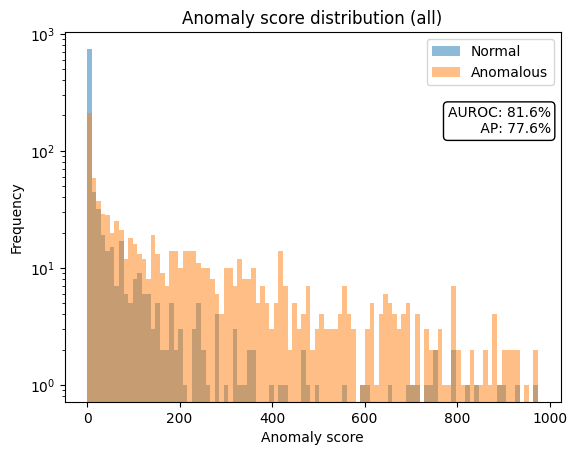

In [23]:
scripts.train_detector(
    cp_task, detector, save_path=None, eval_batch_size=64, batch_size=64
)

# Run Edge Attribution Patching on Hex

In [32]:
from eap.eap_wrapper import EAP

In [33]:
device = "mps"

In [34]:
# TODO: look back at edge attribution example
model.set_use_split_qkv_input(True)
model.set_use_attn_result(True)

In [41]:
# use mean probability over effect tokens as metric 
def effect_prob_func(logits, effect_tokens):
    assert logits.ndim == 3
    probs = logits.softmax(-1)
    # Sum over vocab and batch dim (for now we're just computing attribution values, we'll deal with per data instance later)
    out = probs[:, -1, effect_tokens].mean()
    print("metric", out)
    return out

In [42]:
effect_tokens = torch.tensor(task["effect_tokens"])

In [43]:
trusted_tokens = torch.stack(
    [torch.tensor(x["prefix_tokens"]) for x in cp_task.trusted_data.data], 
    dim=0).to(device)

In [44]:
model.reset_hooks()

graph = EAP(
    model=model,
    clean_tokens=trusted_tokens,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens), 
    # upstream_nodes=["head"],
    # downstream_nodes=["head"],
    batch_size=64
)

Saving activations requires 0.0001 GB of memory per token


  0%|          | 0/256 [00:02<?, ?it/s]


AssertionError: Cannot add hook blocks.0.hook_mlp_in if use_hook_mlp_in is False

In [39]:
top_edges = graph.top_edges(n=20, abs_scores=True)

In [40]:
#TODO: fix the edge attribution code (maybe missing a negative? should trace through)
for from_edge, to_edge, score in top_edges:
    print(f'{from_edge} -> [{round(score, 3)}] -> {to_edge}')

head.2.7 -> [0.0] -> head.3.0.k
head.0.6 -> [-0.0] -> head.1.1.v
head.2.7 -> [0.0] -> head.3.3.k
head.0.6 -> [0.0] -> head.1.0.v
head.0.0 -> [0.0] -> head.2.1.v
head.0.6 -> [-0.0] -> head.2.7.v
head.0.0 -> [-0.0] -> head.3.4.v
head.0.6 -> [-0.0] -> head.1.3.v
head.0.5 -> [0.0] -> head.1.3.v
head.0.0 -> [0.0] -> head.2.7.v
head.0.6 -> [-0.0] -> head.2.1.v
head.0.0 -> [-0.0] -> head.3.3.v
head.1.3 -> [0.0] -> head.2.7.v
head.0.6 -> [-0.0] -> head.1.4.v
head.0.6 -> [-0.0] -> head.2.5.v
head.2.7 -> [0.0] -> head.3.0.q
head.0.3 -> [0.0] -> head.2.7.v
head.0.3 -> [-0.0] -> head.1.7.v
head.1.3 -> [-0.0] -> head.2.5.v
head.1.3 -> [0.0] -> head.3.0.q
